In [1]:
# Import some libraries

import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from matplotlib import pyplot as plt

In [2]:
# Convert vector to image

def to_img(x):
    x = 0.5 * (x + 1)
    x = x.view(x.size(0), 28, 28)
    return x

In [3]:
# Displaying routine

def display_images(in_, out, n=1):
    for N in range(n):
        if in_ is not None:
            in_pic = to_img(in_.cpu().data)
            plt.figure(figsize=(18, 6))
            for i in range(4):
                plt.subplot(1,4,i+1)
                plt.imshow(in_pic[i+4*N])
                plt.axis('off')
        out_pic = to_img(out.cpu().data)
        plt.figure(figsize=(18, 6))
        for i in range(4):
            plt.subplot(1,4,i+1)
            plt.imshow(out_pic[i+4*N])
            plt.axis('off')

In [4]:
# Define data loading step

batch_size = 256

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

dataset = MNIST('./data', transform=img_transform, download=True)
dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [5]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [6]:
# Define model architecture and reconstruction loss

# n = 28 x 28 = 784
d = 30  # for standard AE (under-complete hidden layer)
# d = 500  # for denoising AE (over-complete hidden layer)

class Autoencoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, d),
            nn.Tanh(),
        )
        self.decoder = nn.Sequential(
            nn.Linear(d, 28 * 28),
            nn.Tanh(),
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
    
model = Autoencoder().to(device)
criterion = nn.MSELoss()

In [7]:
# Configure the optimiser

learning_rate = 1e-3

optimizer = torch.optim.Adam(
    model.parameters(),
    lr=learning_rate,
)

*Comment* or *un-comment out* a few lines of code to seamlessly switch between *standard AE* and *denoising one*.

Don't forget to **(1)** change the size of the hidden layer accordingly, **(2)** re-generate the model, and **(3)** re-pass the parameters to the optimiser.

epoch [1/20], loss:0.0551
epoch [2/20], loss:0.0579
epoch [3/20], loss:0.0548
epoch [4/20], loss:0.0505
epoch [5/20], loss:0.0486
epoch [6/20], loss:0.0558
epoch [7/20], loss:0.0553
epoch [8/20], loss:0.0474
epoch [9/20], loss:0.0547
epoch [10/20], loss:0.0508
epoch [11/20], loss:0.0519


/var/folders/fc/zrnq__796h3_r6d5_bqxn56c0000gn/T/ipykernel_57048/156713442.py:7: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(18, 6))


epoch [12/20], loss:0.0510
epoch [13/20], loss:0.0464
epoch [14/20], loss:0.0493
epoch [15/20], loss:0.0487
epoch [16/20], loss:0.0477
epoch [17/20], loss:0.0501
epoch [18/20], loss:0.0473
epoch [19/20], loss:0.0503
epoch [20/20], loss:0.0503


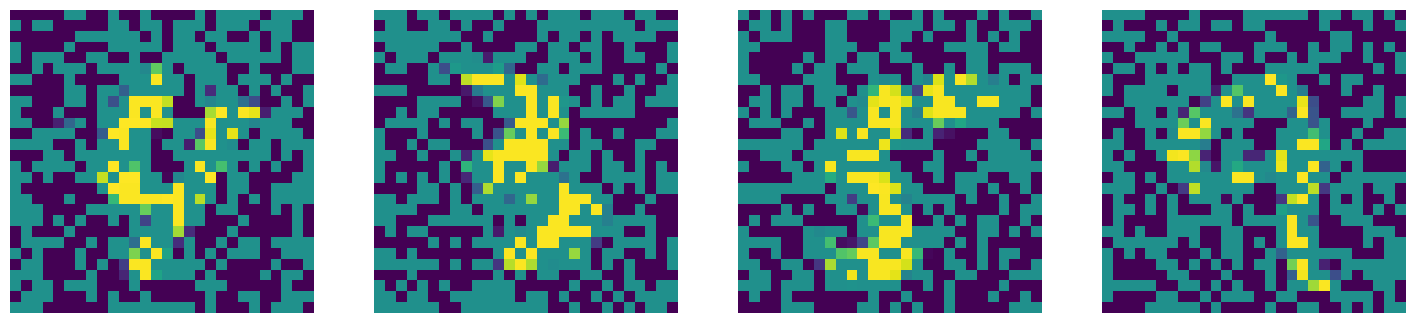

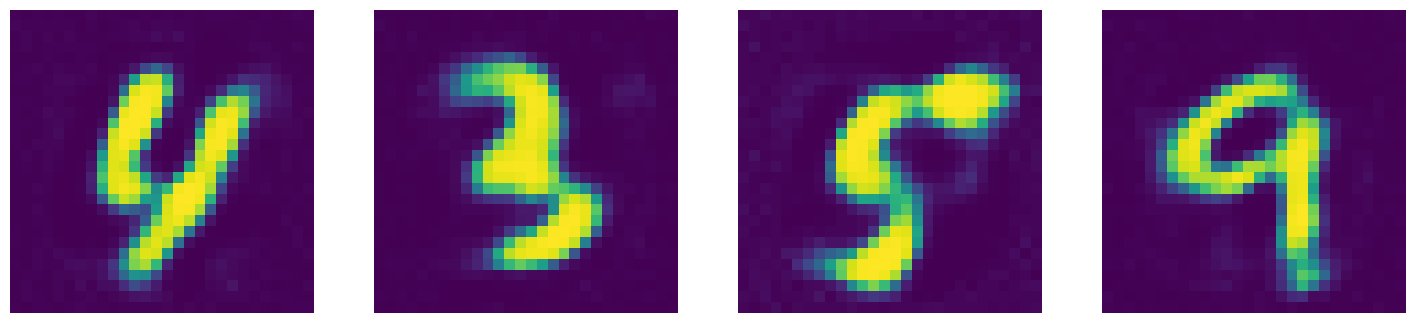

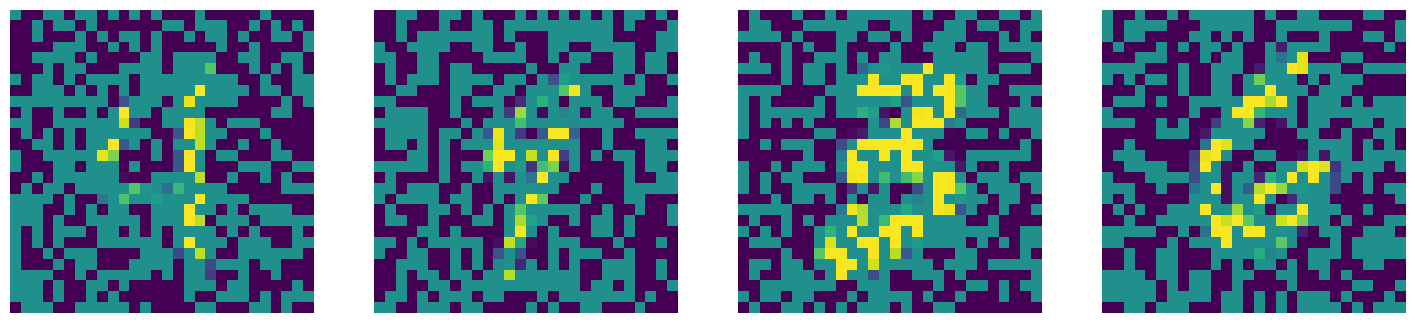

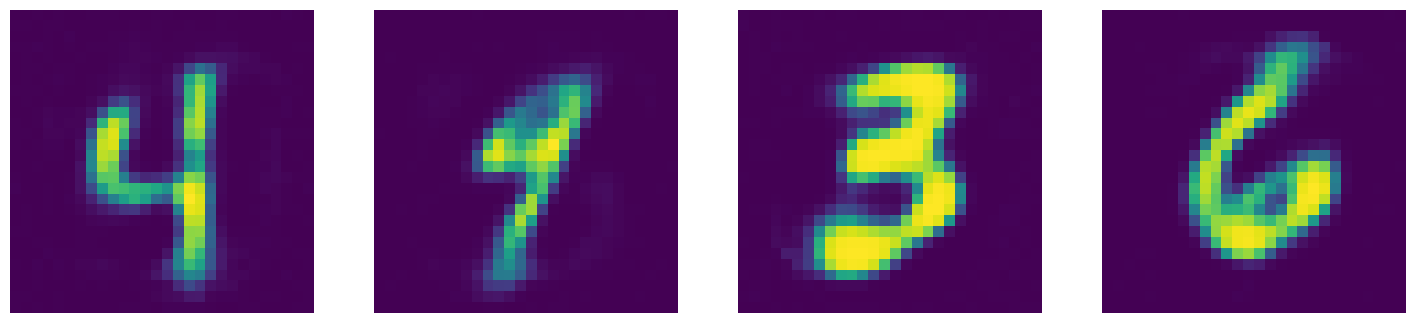

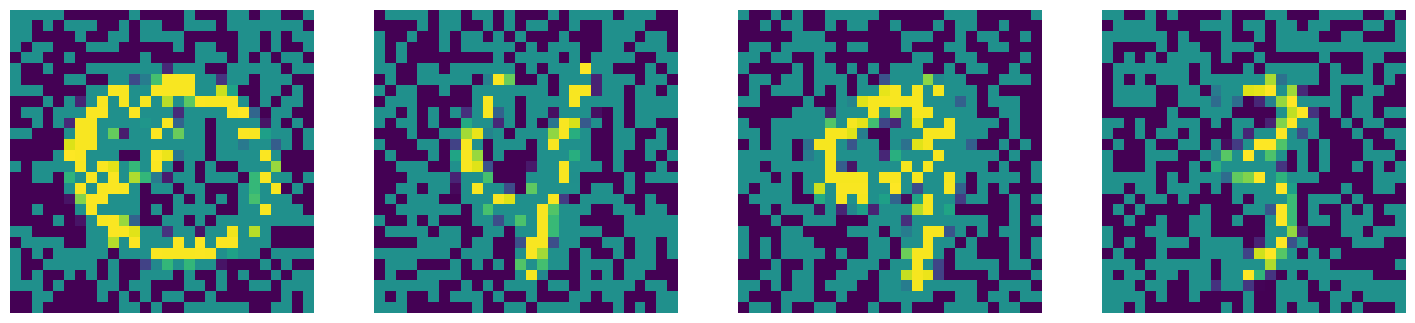

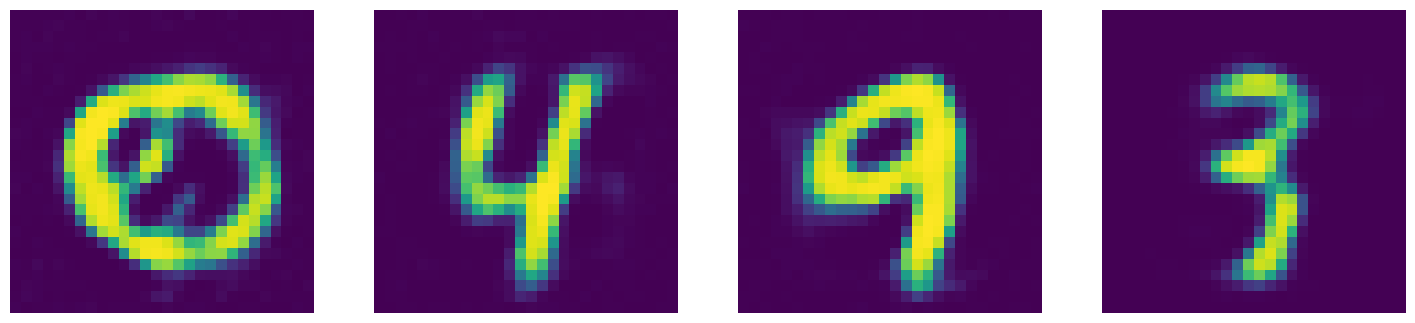

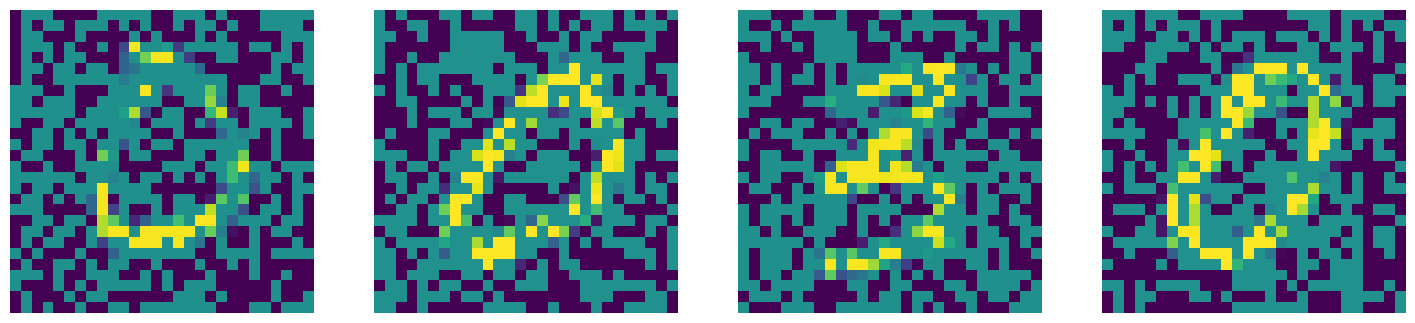

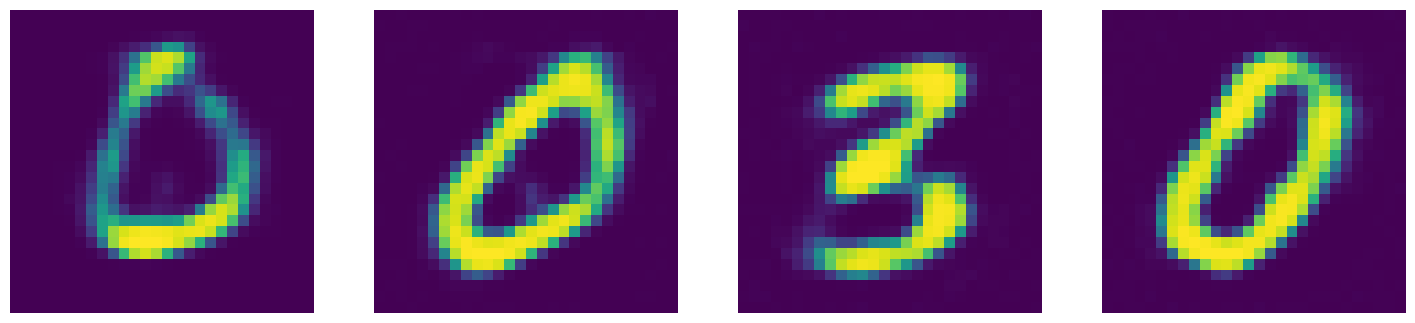

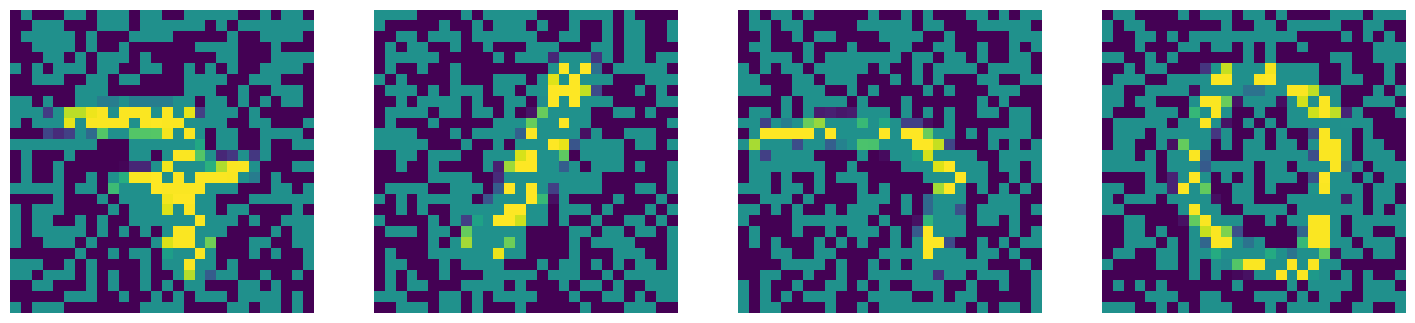

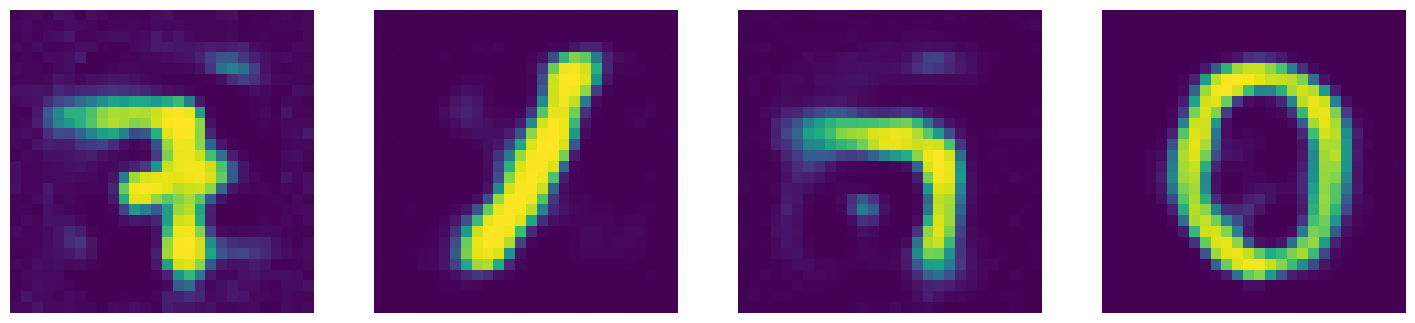

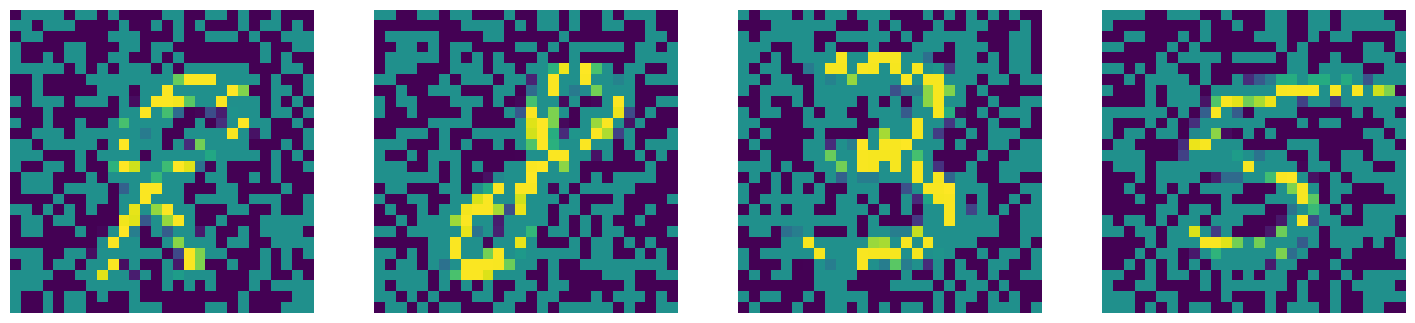

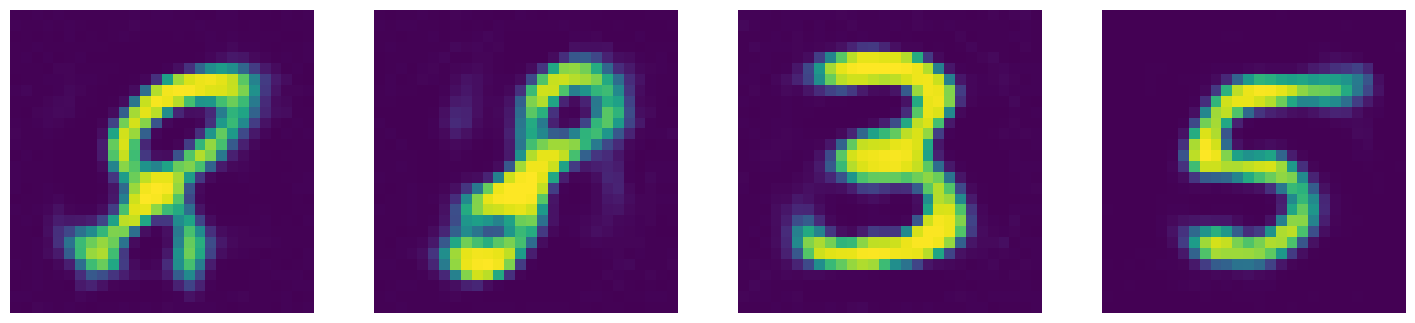

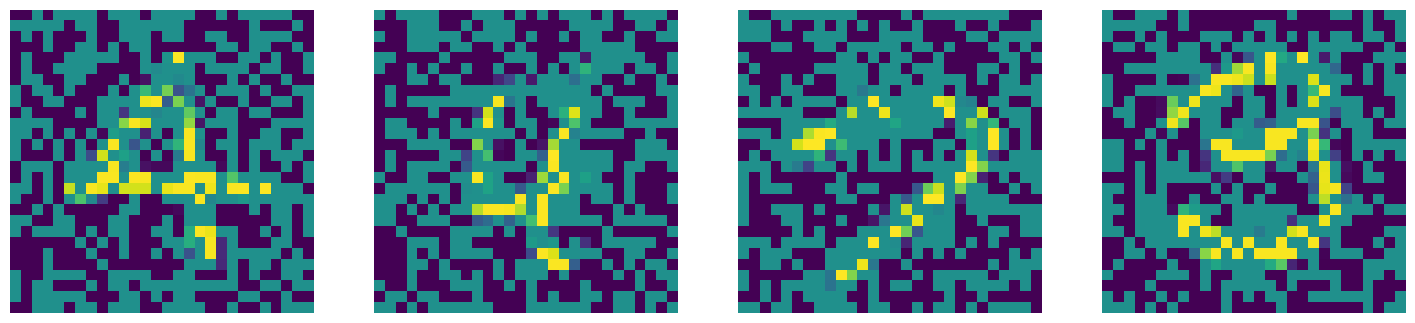

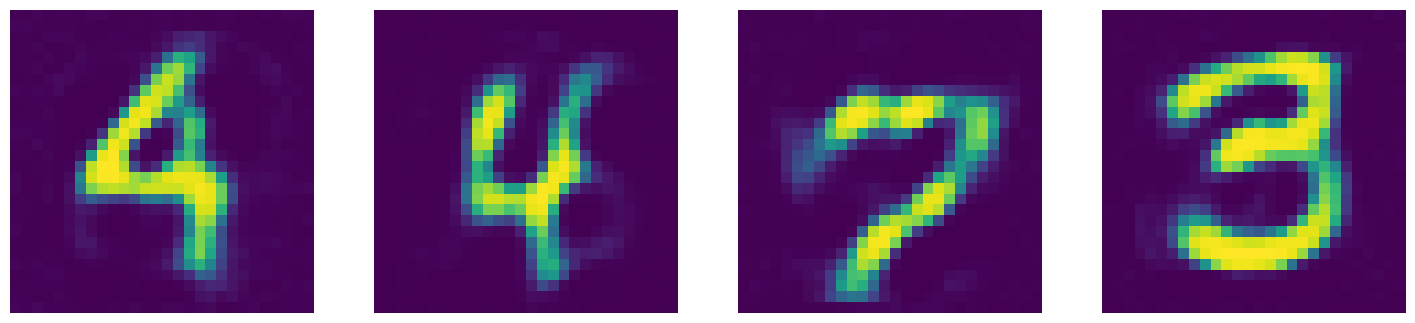

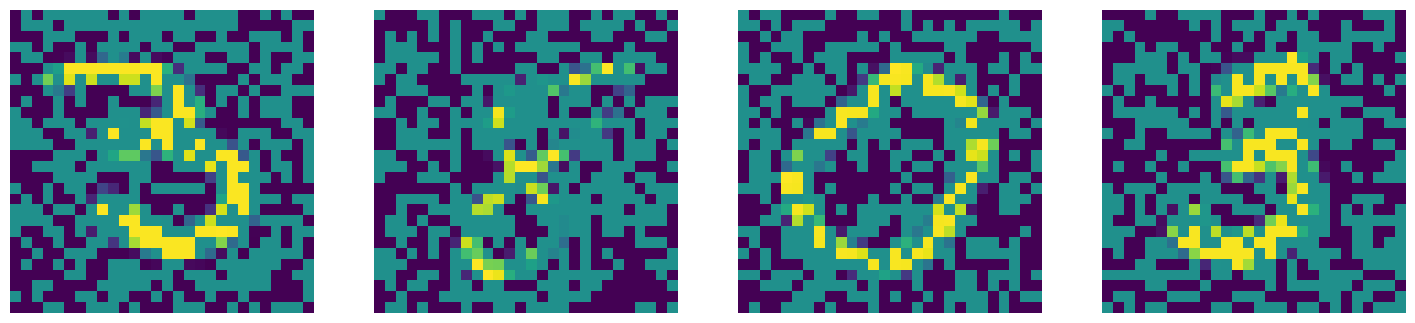

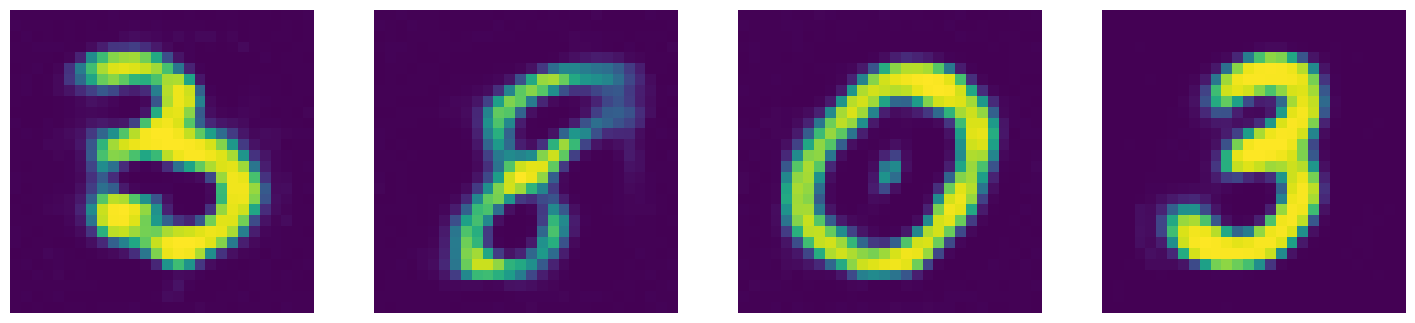

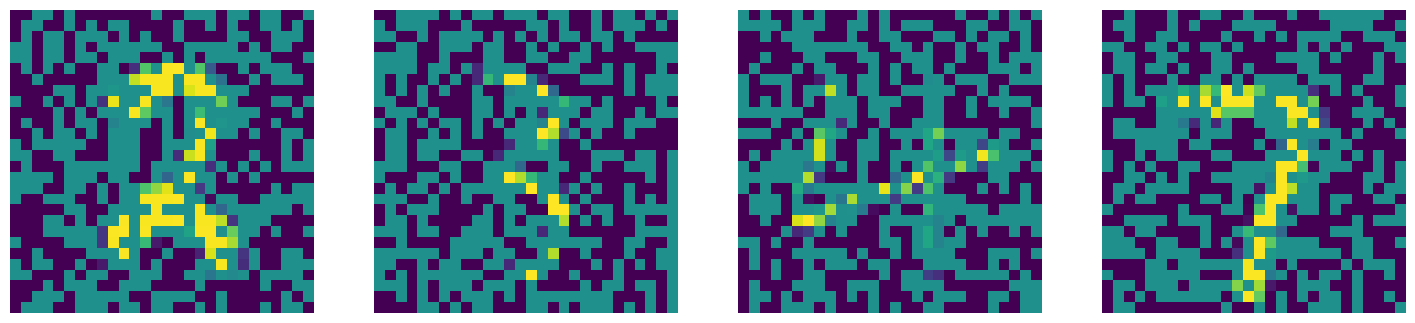

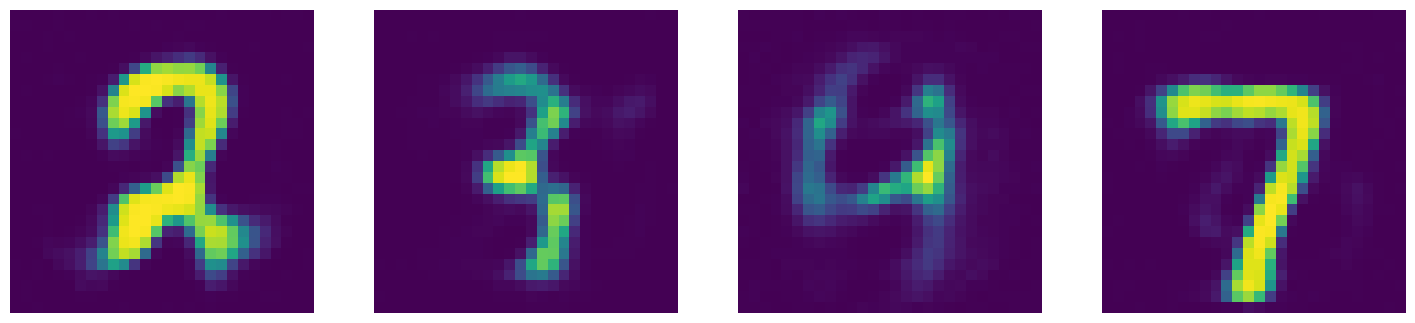

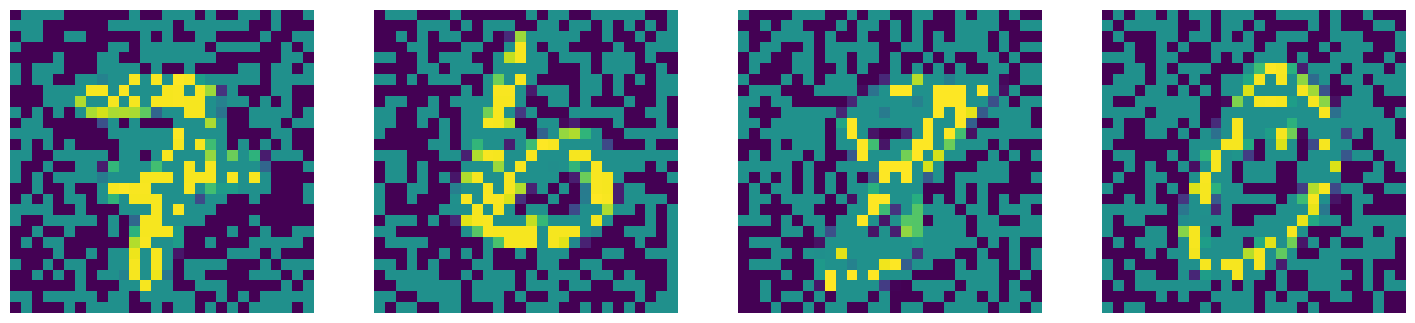

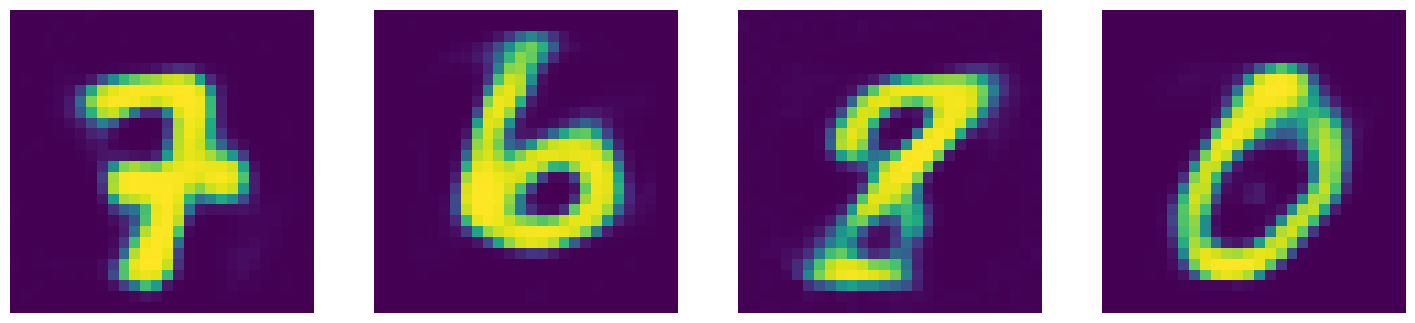

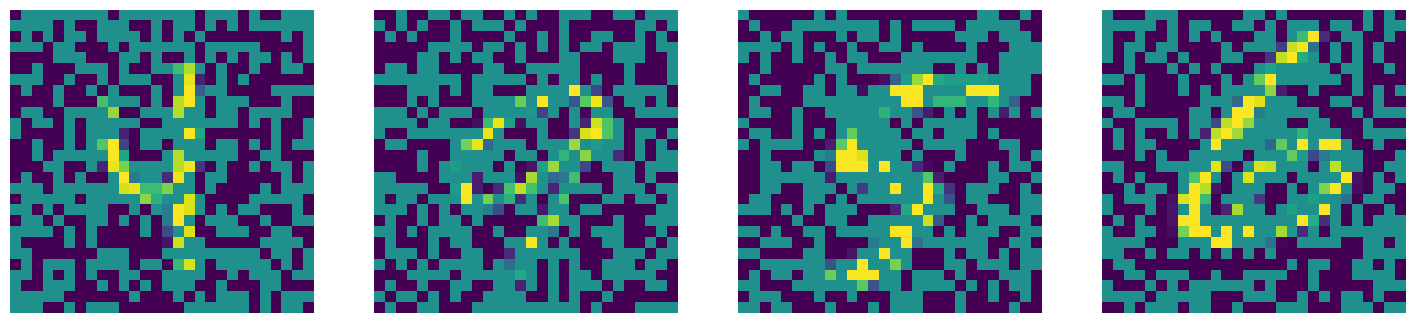

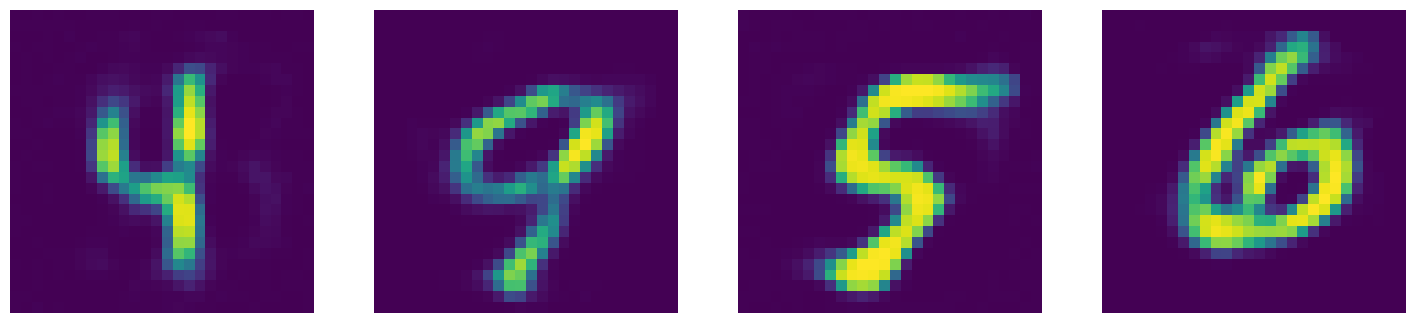

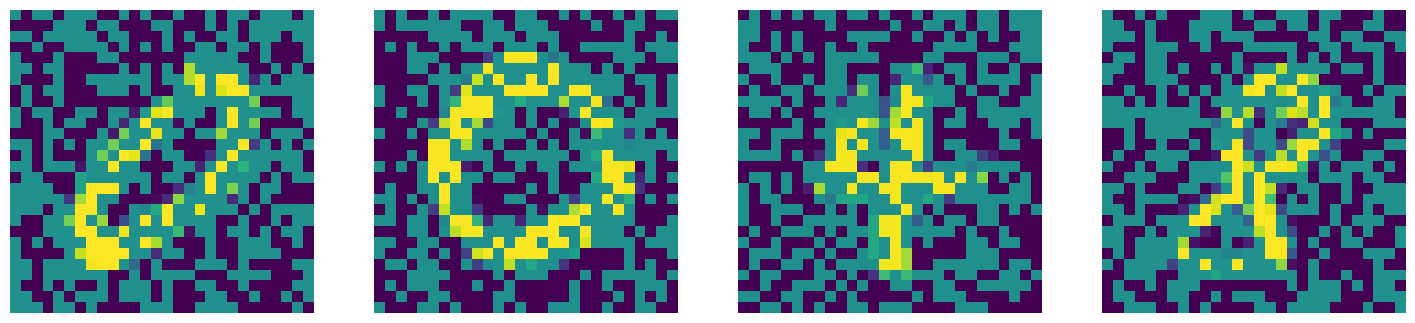

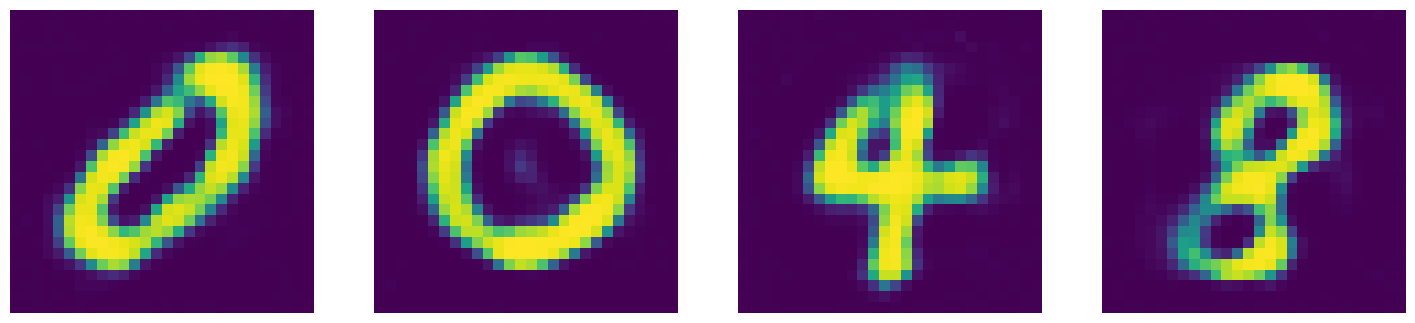

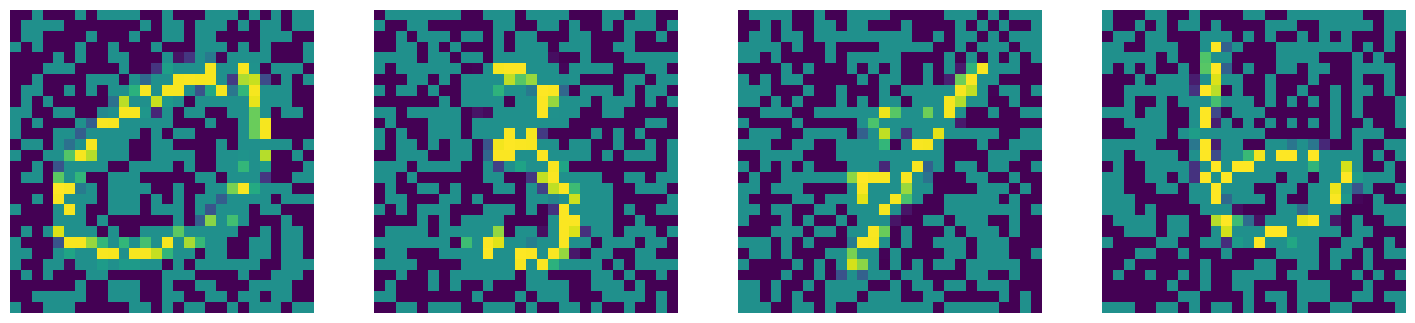

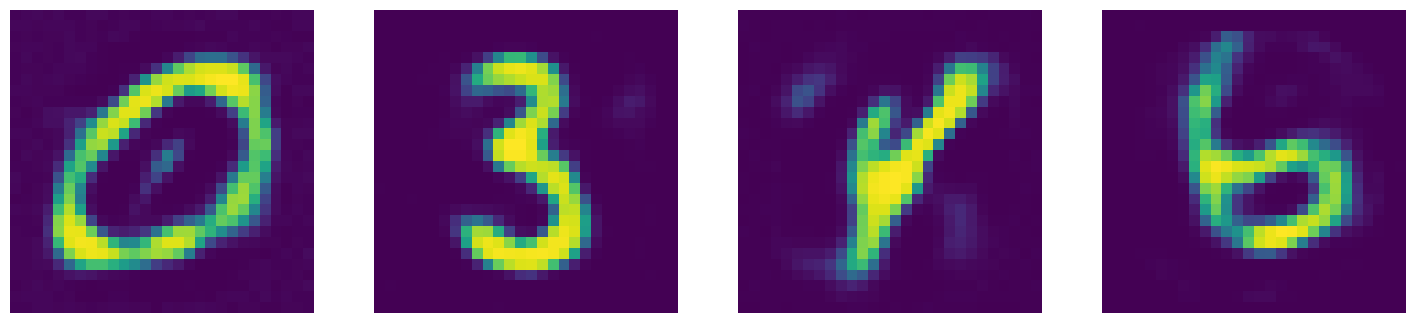

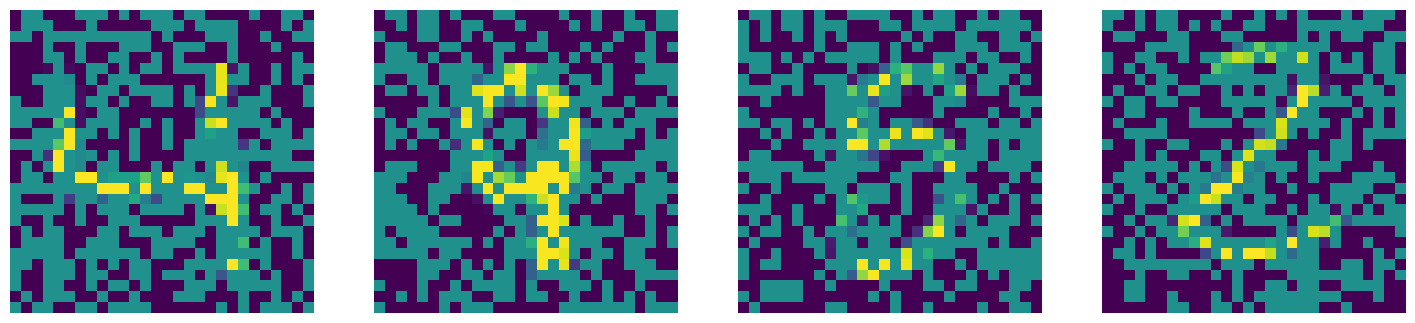

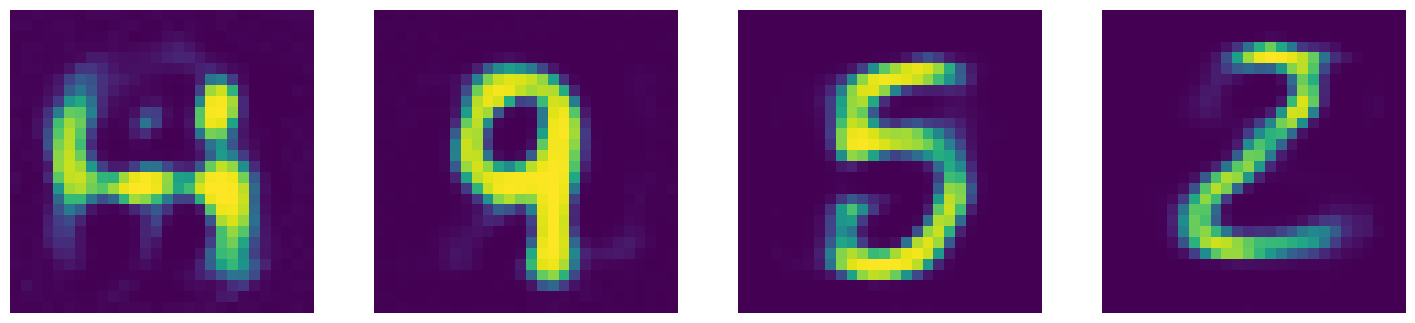

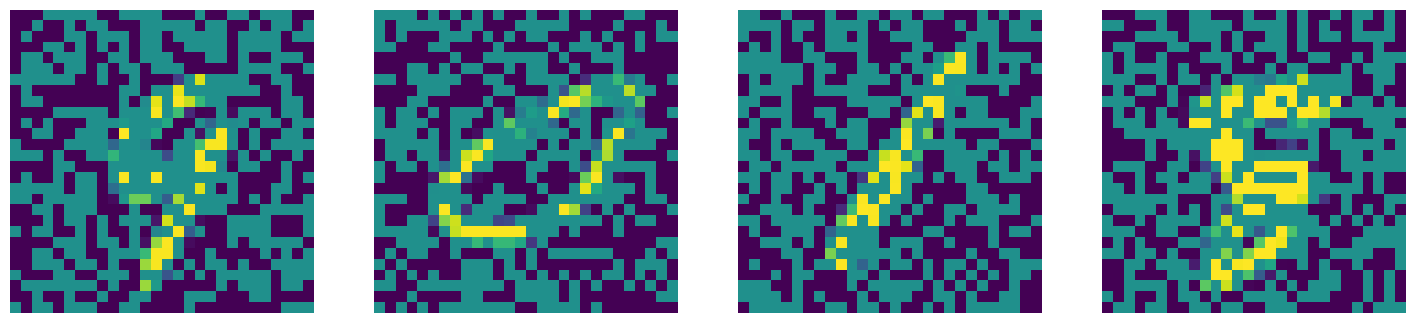

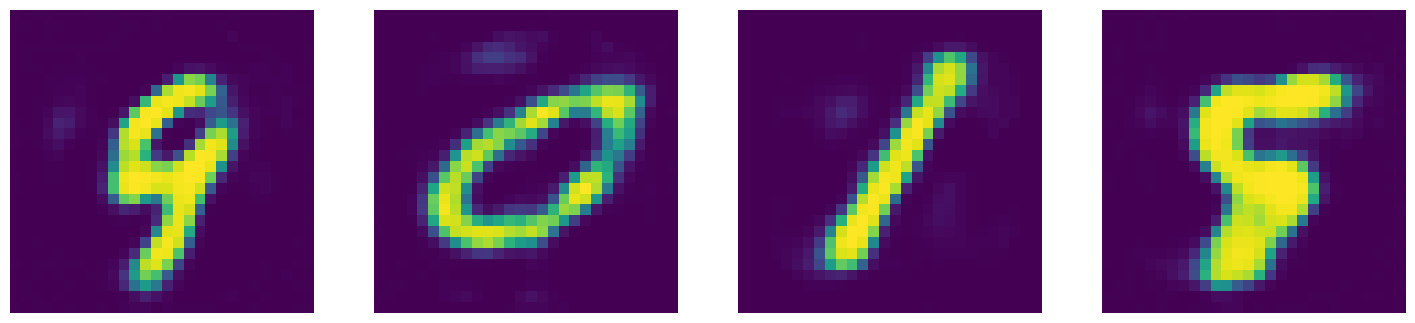

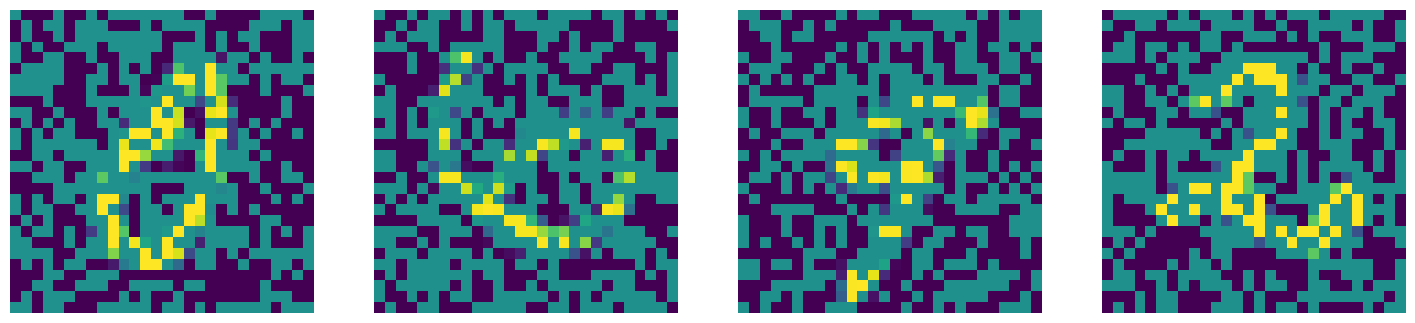

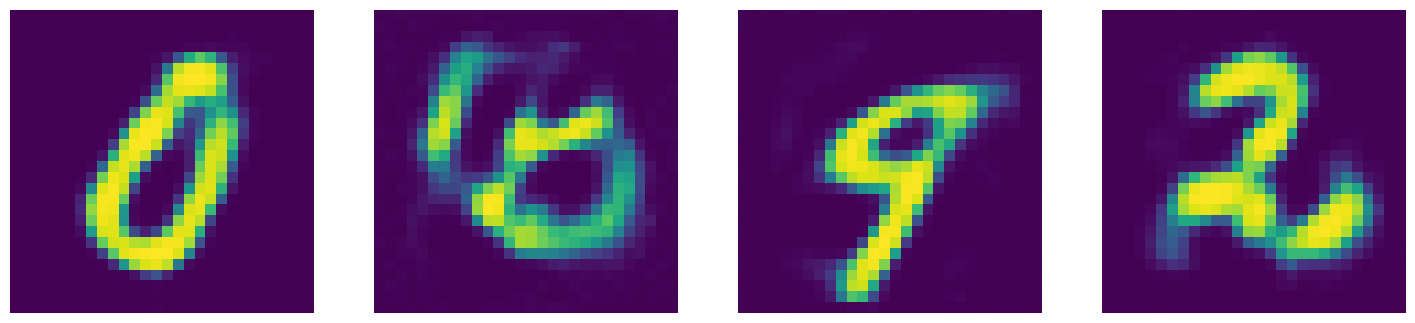

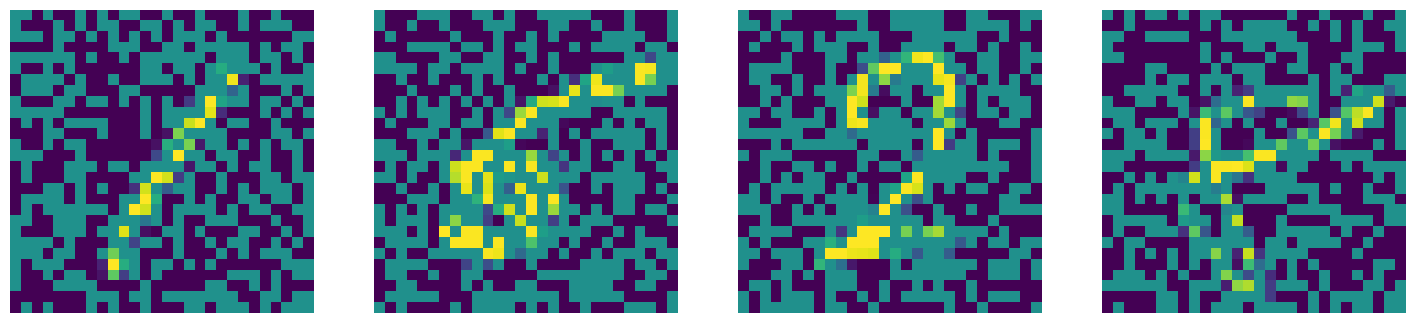

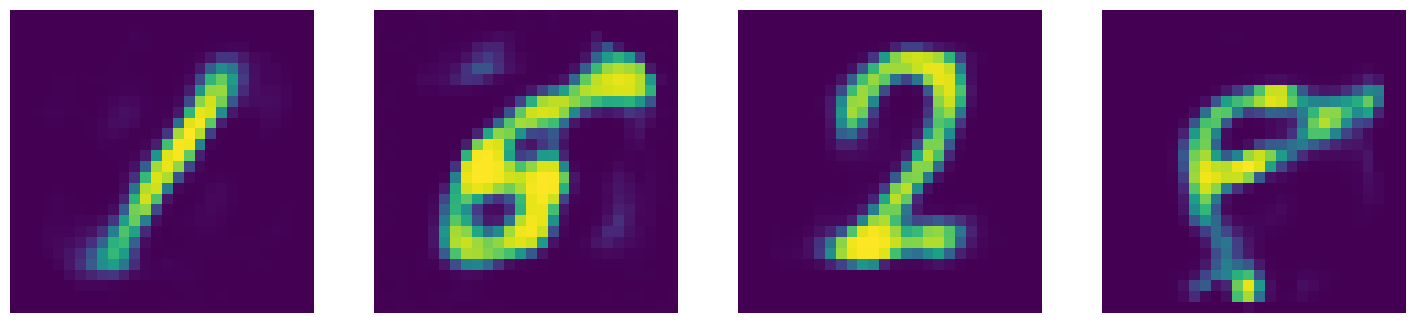

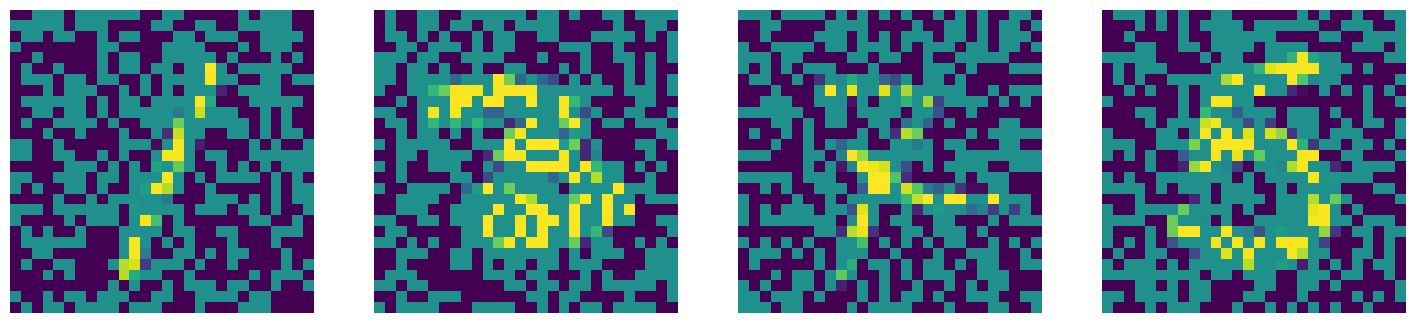

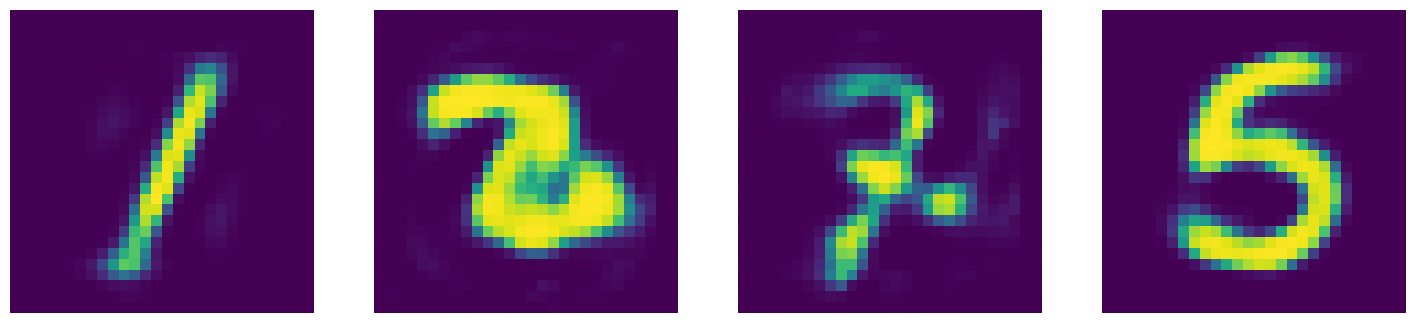

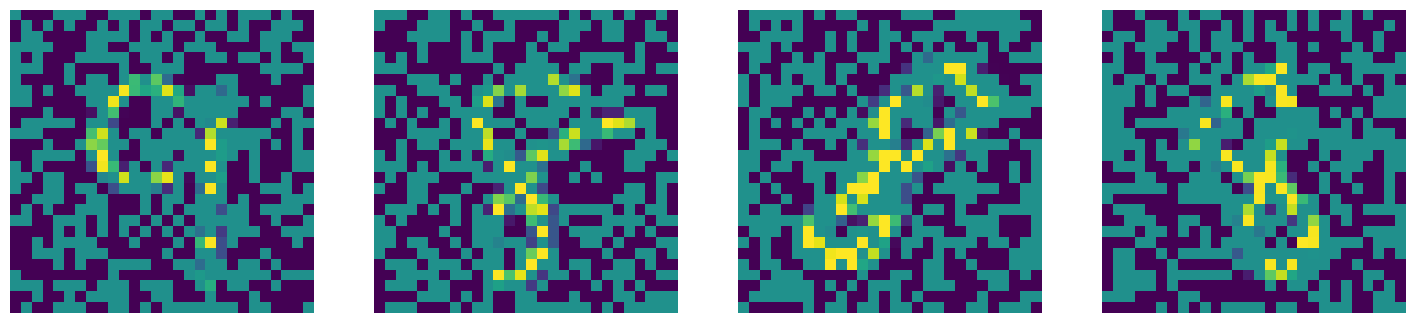

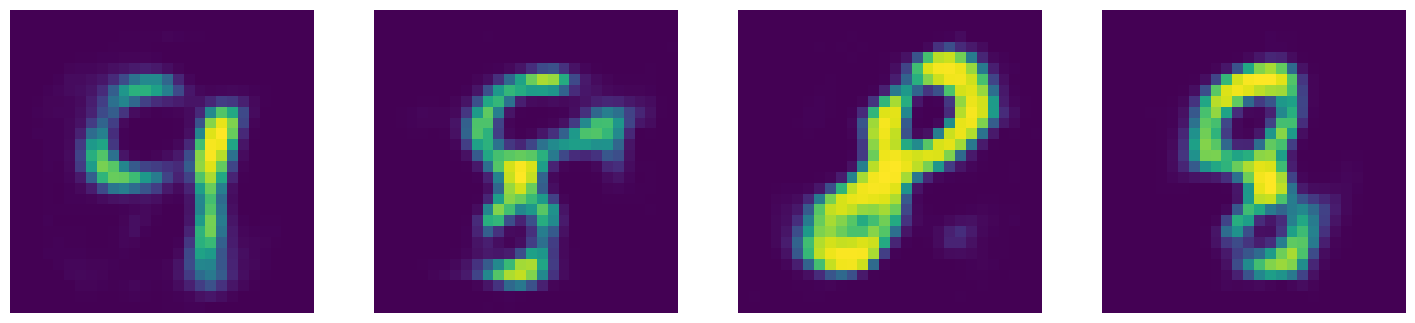

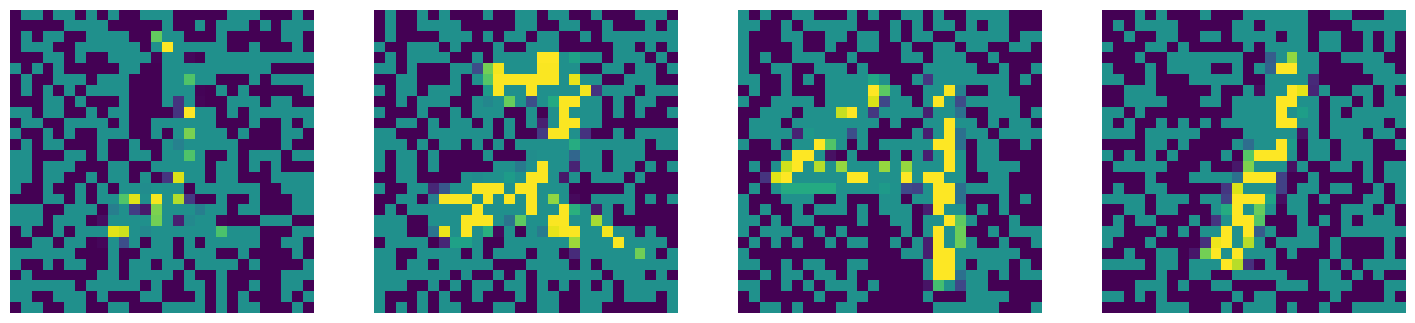

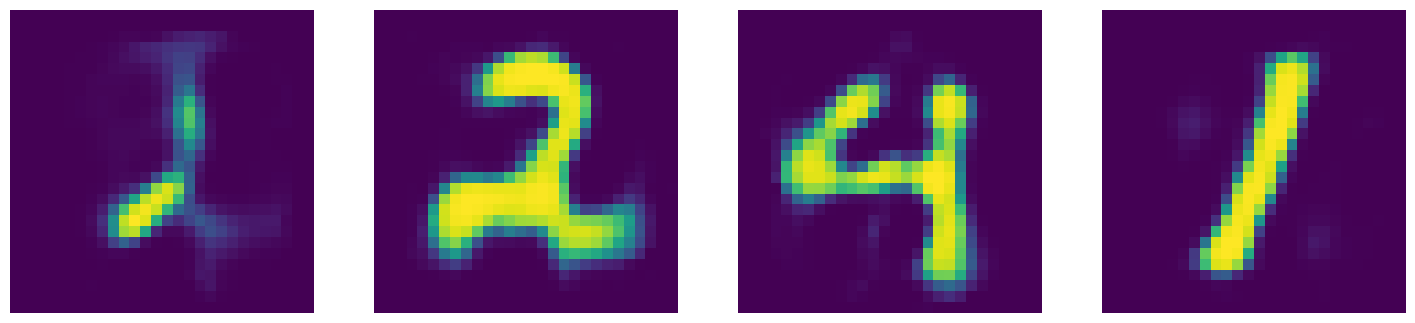

In [12]:
# Train standard or denoising autoencoder (AE)

num_epochs = 20
do = nn.Dropout()  # comment out for standard AE
for epoch in range(num_epochs):
    for data in dataloader:
        img, _ = data
        img = img.to(device)
        img = img.view(img.size(0), -1)
        noise = do(torch.ones(img.shape)).to(device)
        img_bad = (img * noise).to(device)  # comment out for standard AE
        # ===================forward=====================
        output = model(img)  # feed <img> (for std AE) or <img_bad> (for denoising AE)
        loss = criterion(output, img.data)
        # ===================backward====================
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    # ===================log========================
    print(f'epoch [{epoch + 1}/{num_epochs}], loss:{loss.item():.4f}')
    display_images(img_bad, output)  # pass (None, output) for std AE, (img_bad, output) for denoising AE

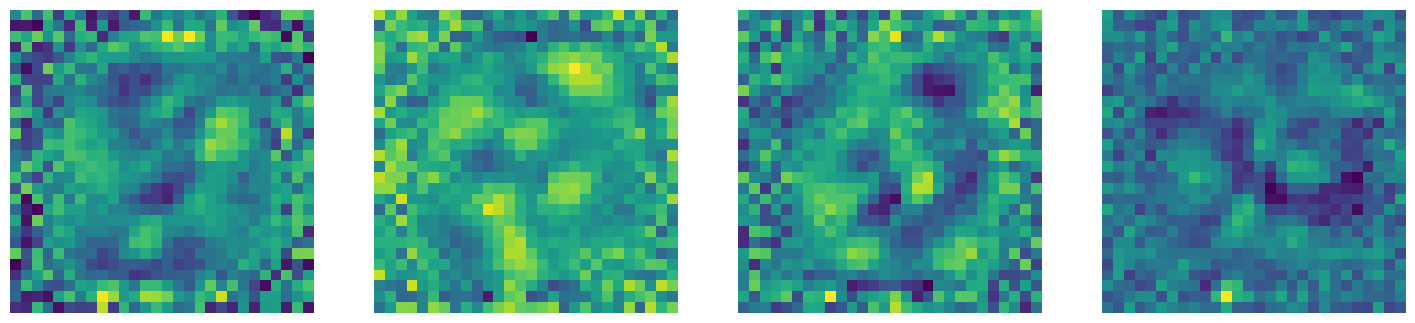

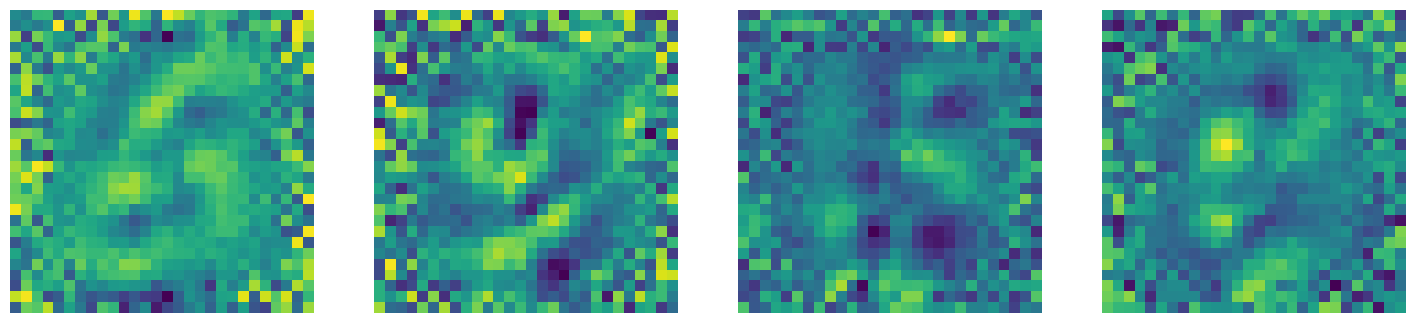

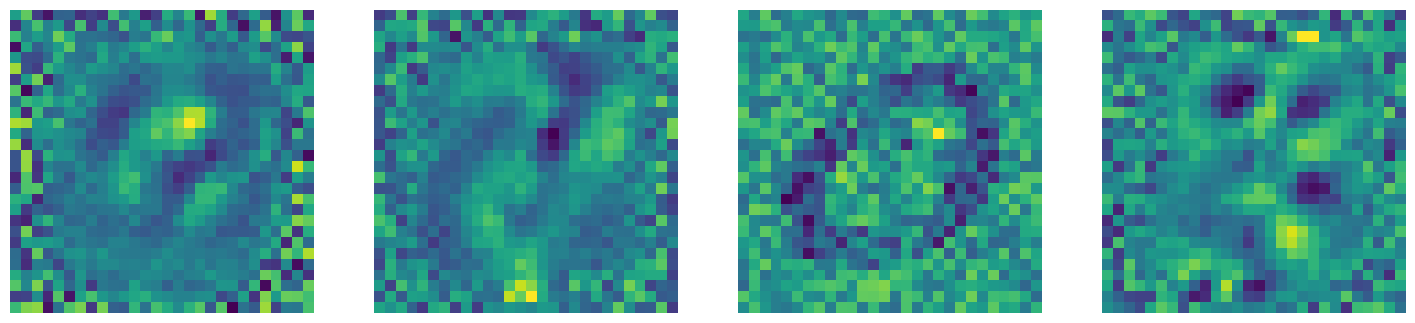

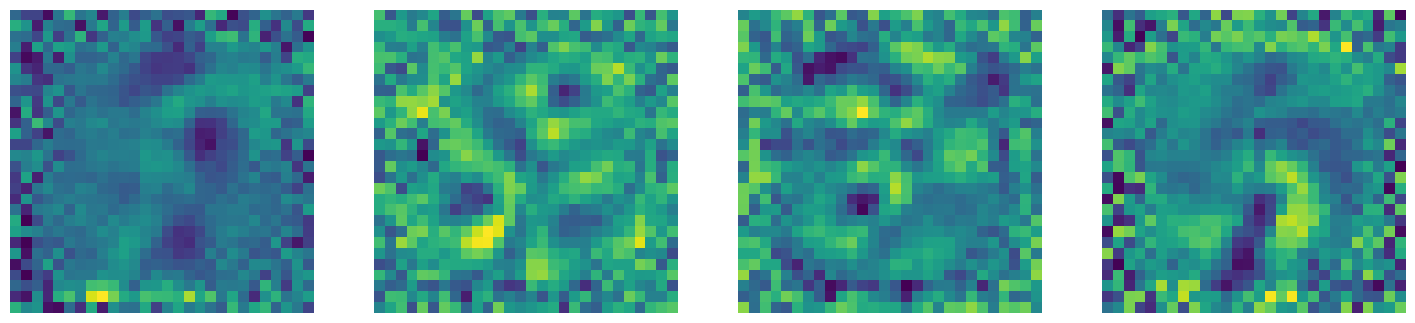

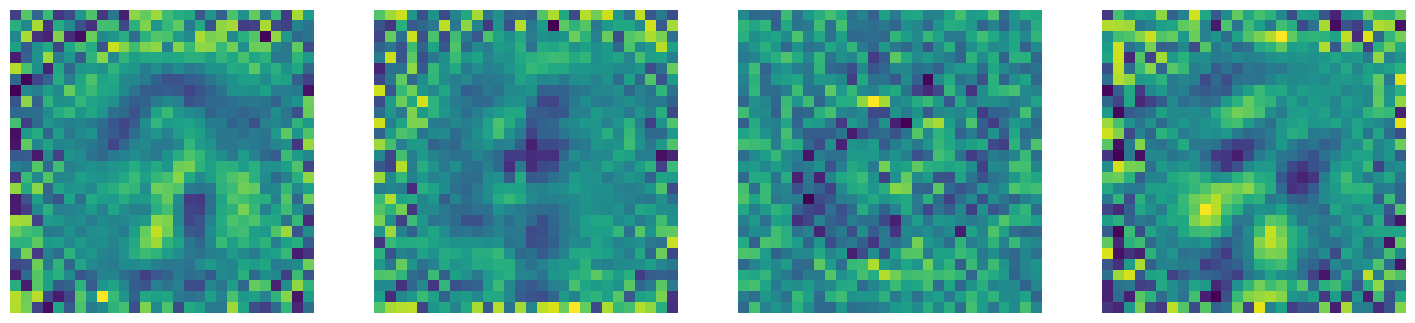

In [13]:
# Visualise a few kernels of the encoder

display_images(None, model.encoder[0].weight, 5)

In [14]:
# Let's compare the autoencoder inpainting capabilities vs. OpenCV
# RUN THIS ONLY AFTER HAVING TRAINED A DENOISING AE!!!

from cv2 import inpaint, INPAINT_NS, INPAINT_TELEA

In [15]:
# Inpaint with Telea and Navier-Stokes methods

dst_TELEA = list()
dst_NS = list()

for i in range(3, 7):
    corrupted_img = ((img_bad.data.cpu()[i].view(28, 28) / 4 + 0.5) * 255).byte().numpy()
    mask = 2 - noise.cpu()[i].view(28, 28).byte().numpy()
    dst_TELEA.append(inpaint(corrupted_img, mask, 3, INPAINT_TELEA))
    dst_NS.append(inpaint(corrupted_img, mask, 3, INPAINT_NS))

tns_TELEA = [torch.from_numpy(d) for d in dst_TELEA]
tns_NS = [torch.from_numpy(d) for d in dst_NS]

TELEA = torch.stack(tns_TELEA).float()
NS = torch.stack(tns_NS).float()

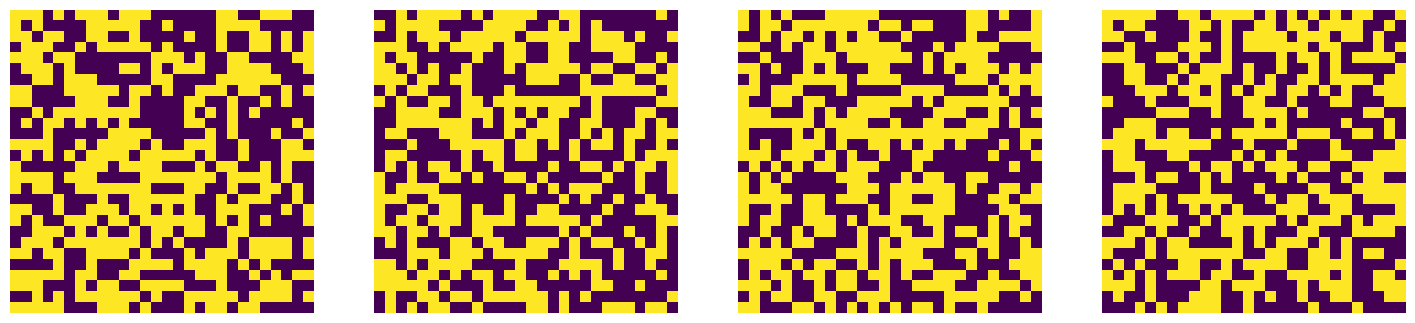

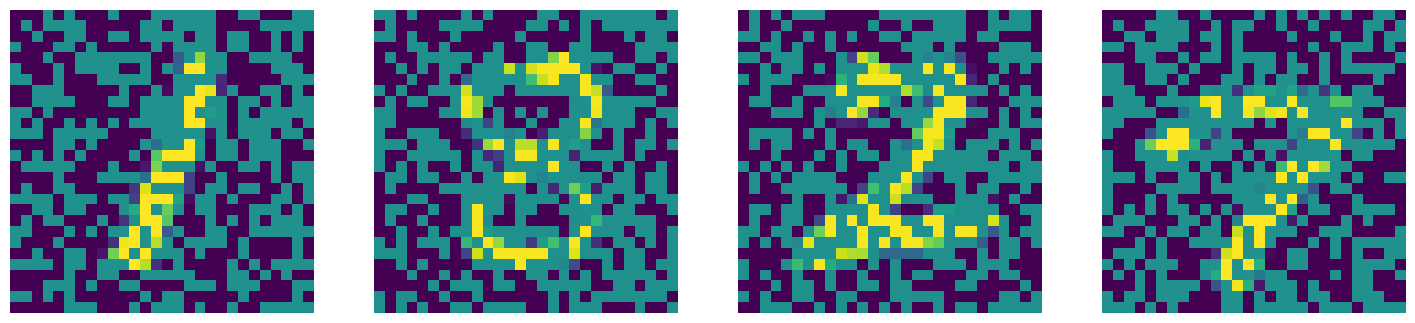

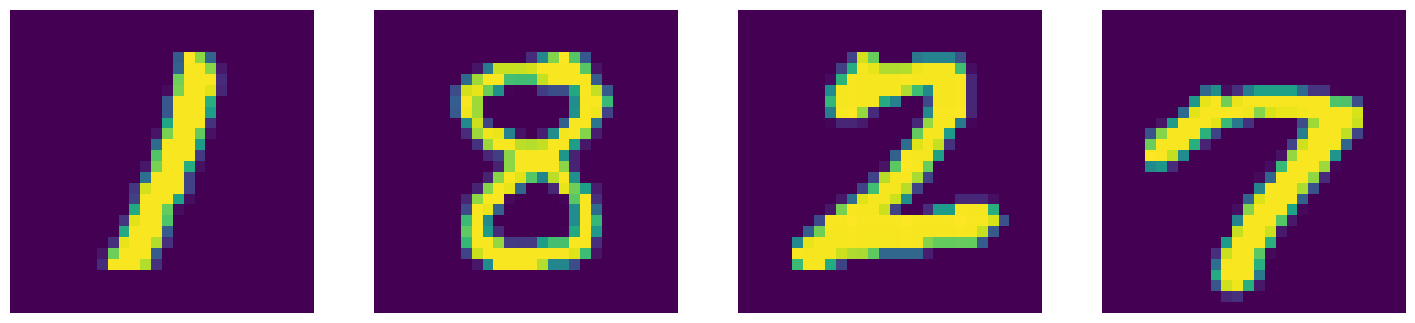

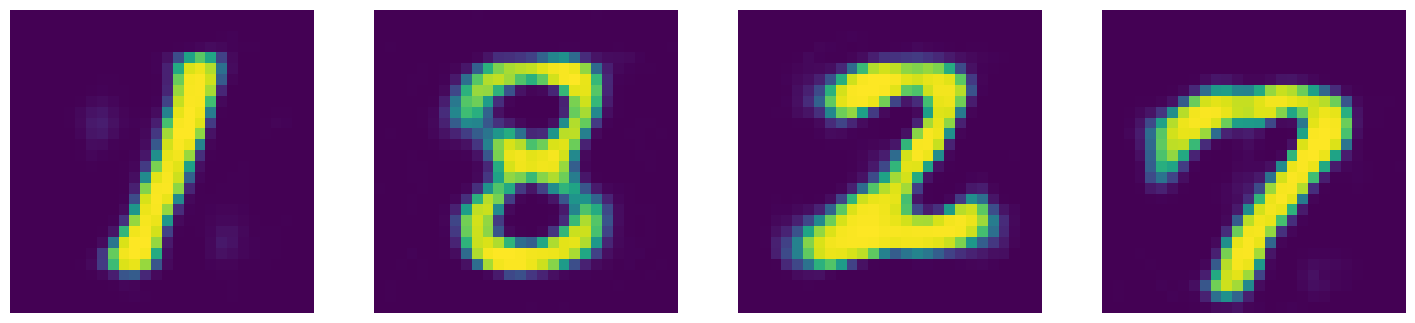

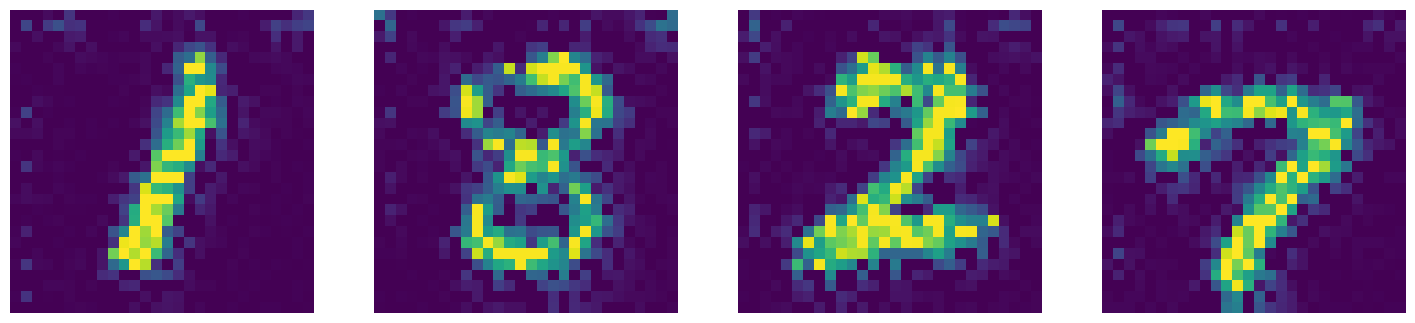

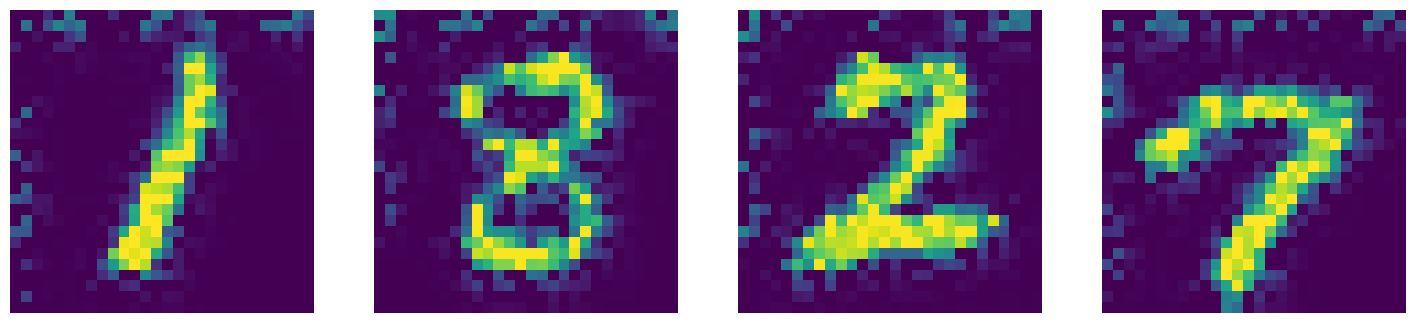

In [16]:
# Compare the results: [noise], [img + noise], [img], [AE, Telea, Navier-Stokes] inpainting

with torch.no_grad():
    display_images(noise[3:7], img_bad[3:7])
    display_images(img[3:7], output[3:7])
    display_images(TELEA, NS)